# Automated QUBO Solver using the Quantum Adiabatic Algorithm - Showcase and Tutorial

## 1. Introduction
The following notebook gives an overview of what happens behind the scenes for the automated Quantum Adiabatic Algorithm (QAA) QUBO solver from QuRAWC using Pulser on an Analog Quantum Computer. In the full QuRAWC algorithm, showcased in the `QuRAWC_tuto.ipynb` notebook, everything done in this notebook is automated and seamlessly and robustly integrated with the other components of the full QuRAWC algorithm.

That being said, the purpose of this tutorial is to serve as a demo/showcase for our quantum algorithm. The $Q$ matrix chosen for the QUBO in this showcase is of lesser dimensionality than the ones processed in the real algorithm, but it is nonetheless used here in order to make the showcase simpler and its simulations/optimizations faster to run. For a more thorough and detailed algorithmic and mathematical breakdown of the functions and algorithm contain herein, please refer to the Technical Project Report deliverable.

We begin by importing all the necessary packages as well as the `optim.py` module script. This script contains all the functions used for solving the QUBO, and it has to be in the same directory as this notebook.

In [2]:
import sys
sys.path.append("../code")

import numpy as np
import matplotlib.pyplot as plt
import pulser
import pulser_simulation
import sympy
from skopt import gp_minimize
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform, euclidean

from quantum import optim

### 1.1 Defining the $Q$ matrix

The QUBO instance we are trying to solve is defined by the matrix $Q$. In the `QuRAWC.ipynb` notebook, this matrix is generated from the previous parts of the QuRAWC algorithm pipeline. However, in this tutorial we directly define an arbitrary $Q$ matrix in order to effectively showcase this part of the QuRAWC algorithm.

The matrix is a 6×6 square matrix, meaning its solution is a 6-bit bitstring. Each bit corresponds to a binary variable that indicates whether a firefighter should be deployed at a specific location on a 2×3 grid in this example. (*Please refer to the Technical Project Report deliverable for more detailed information about this encoding of the QUBO problem*).

In [2]:
Q = np.array(
    [
        [-10.0004, 19.7359, 19.7209, 5.4253, 5.4201, 13.4356],
        [19.7359, -15.0291, 20.6762, 12.1767, 3.8123, 0.8561],
        [19.7209, 20.6762, -18.0108, 0.8563, 13.7167, 0.1765],
        [5.4253, 12.1767, 0.8563, -10.1232, 1.3234, 1.3336],
        [5.4201, 3.8123, 13.7167, 1.3234, -4.5544, 7.4909],
        [13.4356, 0.8561, 0.1765, 1.3336, 7.4909, -3.232]
    ]
)
sympy.Matrix(Q) # we print it as a sympy matrix to visualize it more clearly

Matrix([
[-10.0004,  19.7359,  19.7209,   5.4253,  5.4201, 13.4356],
[ 19.7359, -15.0291,  20.6762,  12.1767,  3.8123,  0.8561],
[ 19.7209,  20.6762, -18.0108,   0.8563, 13.7167,  0.1765],
[  5.4253,  12.1767,   0.8563, -10.1232,  1.3234,  1.3336],
[  5.4201,   3.8123,  13.7167,   1.3234, -4.5544,  7.4909],
[ 13.4356,   0.8561,   0.1765,   1.3336,  7.4909,  -3.232]])

### 1.2 Classicaly solving the $Q$ matrix

Firstly, we classicaly solve the QUBO in order to evaluate the result of the QAA at the end. This is of course not possible for QuRAWC when working online, but we still do it in this tutorial to showcase how the solution is found. This is done is the same way as the [QAOA and QAA to solve a QUBO problem](https://pulser.readthedocs.io/en/stable/tutorials/qubo.html) tutorial in the Pulser documentation.

We can see that the solution is `001101` with an associated cost of around -26.63, which (in the context of QuRAWC) means that it would be most optimal to deploy firefighters to the 3rd, 4th, and 6th location in our map.

In [3]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('001101', -26.633200000000002), ('001100', -26.4214), ('001001', -20.8898)]


## 2. Embedding $Q$ onto an atomic register

Firstly, we need to embed the $Q$ matrix onto an atomic register. Given that we are working with a 6×6 matrix, we will need six atoms in the device register. Furthermore, the values on the diagonal are not equal, so we will need to perform weighted analog quantum computing by combining the `Rydberg.Global` channel with a `DMM` channel in order to modulate the detunings of the different atoms in the register. Thus, we choose the `DigitalAnalogDevice` as it contains both channels and also has some physical constraints, which would make our Sequence more realistic than using the `MockDevice`.

In order to find the coordinates of the atoms in the register, we invoke the `coords_optim` function from the `optim` module, which optimizes atom coordinates to minimize their deviation from the target QUBO matrix $Q$. Internally, this function calls on the `evaluate_mapping` function (also in the `optim` module) and minimizes it using the L-BFGS-B method. Refer to the `optim.py` script to see the code, and refer to the Technical Report Project deliverable for a more detailed explanation of how the atom coordinates are optimized.

In [4]:
device = pulser.DigitalAnalogDevice
coords = optim.coords_optim(Q, verbose=True, device=device)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.465123978742721
        x: [ 1.722e+01 -1.024e+01  2.134e+01 -3.308e+00  1.334e+01
            -3.166e+00  2.719e+01 -9.796e+00  7.309e+00 -9.248e+00
             1.232e+01 -1.730e+01]
      nit: 172
      jac: [ 3.553e-07  8.882e-08  5.329e-07  5.329e-07  1.776e-07
             4.441e-07  2.665e-07  1.776e-07  4.441e-07  4.441e-07
             8.882e-08  2.665e-07]
     nfev: 3640
     njev: 280
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>


From the output, we can see that the final value of the Frobenius norm of the difference of the $Q$ matrix we are trying to embed and the $Q_{new}$ matrix embedded in the register is ~5.46, which is not outstanding but definitely good enough. Next, we can build the register and see what it looks like:

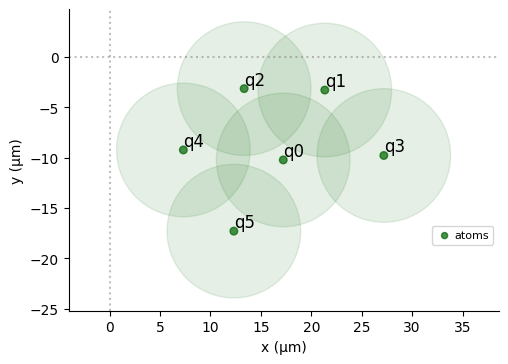

In [5]:
# Building the register:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = pulser.Register(qubits)
reg.draw(
    blockade_radius=device.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

The register has successfuly been built and displayed, so no physical constraints imposed by the device have been broken and the atom coordinates yield a valid register. Now we can proceed with optimizing the Sequence for the QAA.

## 3. Obtaining the Sequence

**Note**: *the cells in the following section need to be run in order, and each cell needs to be run exactly once. Otherwise, multiple copies of the pulse will be added to the Sequence and the QAA will not work properly. Just run this section from the beginning in case this happens.*

First, we initialize the Sequence, decleare the `rydberg-global` channel and calculate the maximum Rabi frequency $\Omega$ and maximum detuning $\delta$ that the device can physically produce. The Sequence is later optimized using a Bayesian search so we will need these values to define the parameter space.

In [6]:
sequence = pulser.Sequence(reg, device)
sequence.declare_channel("rydberg_global", "rydberg_global")

tol = 1e-6
max_omega = sequence.declared_channels["rydberg_global"].max_amp * (1 - tol)
max_det = sequence.declared_channels["rydberg_global"].max_abs_detuning * (1 - tol)
print("Max Omega: " + str(max_omega) + "\nMax delta: " + str(max_det))

Max Omega: 15.707947559985698
Max delta: 125.66358047988558


After doing this, we proceed with the detuning map from the diagonal elements of $Q$. This is done using the `normalize_det_map` function from the `optim` module, which gives a $\epsilon_{DMM}=0$ coefficient for the penalty detuning of the most favourable atom (the one whose associated cost on the diagonal of $Q$ is the lowest), a $\epsilon_{DMM}=1$ for the least favourable atom (conversely, the one with the highest cost in the diagonal of $Q$), and maps the other atoms' $\epsilon_{DMM}$ coefficients between zero and one based on their values.

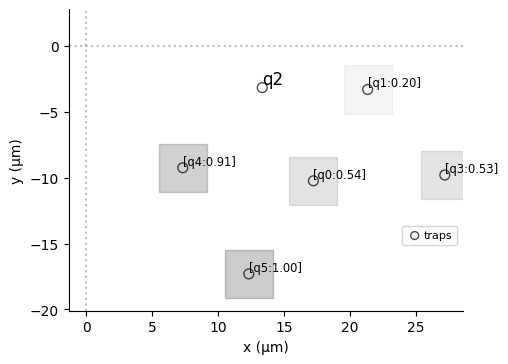

In [7]:
diag_costs = np.diag(Q)
det_map_weights = optim.normalize_det_map(diag_costs)
det_map = reg.define_detuning_map(
    {f"q{i}": det_map_weights[i] for i in range(len(det_map_weights))}
)
det_map.draw(labels=reg.qubit_ids)

sequence.config_detuning_map(det_map, "dmm_0")

### 3.1 Setting up the interpolated pulses

This is done in a very similar manner to the [Optimal Control for AFM State Preparation](https://pulser.readthedocs.io/en/stable/tutorials/optimization.html) tutorial in the Pulser documentation. The only difference is that we are using a detuning map, so there is one more parameter that needs to be optimized.

Namely, the parameters fed to the optimization algorithm must uniquely define $\Omega$, $\delta$, and the penalty detuning $\delta_{DMM}$. Thus, the interpolated pulses can be fully described by $2m+1$ parameters, where $m$ is the number of points which define the monotonic cubic splines the final pulse is defined from.

In [8]:
m = 3 # number of points to be optimized

# Parameter constraints
Omega = optim.compute_min_interaction(Q, device)
Omega_max = min(Omega, max_omega)
Omega_max = max_omega

delta_0 = -Omega_max
delta_f = -delta_0
delta_bounds = (delta_0, delta_f)

T = 20000  # time in ns

`compute_min_interaction` is a function from the `optim` module which computes the minimal interaction between the atoms in the register based on the $Q$ matrix, and is used as a heuristic for the maximum $Omega$ value in order to ensure an adiabatic path from the initial to the final Hamiltonian. In case this minimal interaction is too large for the physical constraints of the device, we just take the maximum value allowed by the device as the maximum of the $\Omega$ parameter space. We take $\delta_0$ as $-\Omega_{max}$ also as a heuristic, and we choose a pulse duation time of 20000 nanoseconds. This value for the pulse duration is chosen because this code has to run automatically in the full QuRAWC setup, and this is the most optimal value we could find. For more information, refer to the Technical Project Report deliverable.

Before going further, let us check that everything works by demonstrating a Sequence with random values for the parameters. The interpolated pulse is created using the `create_interp_pulse` function from the `optim` module.

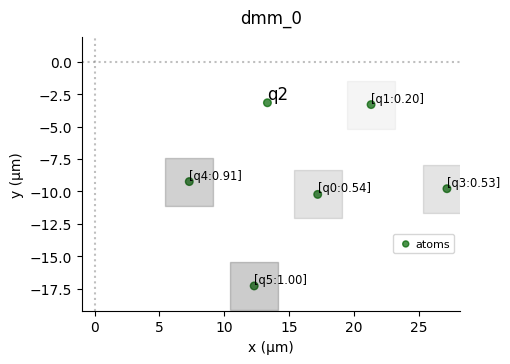

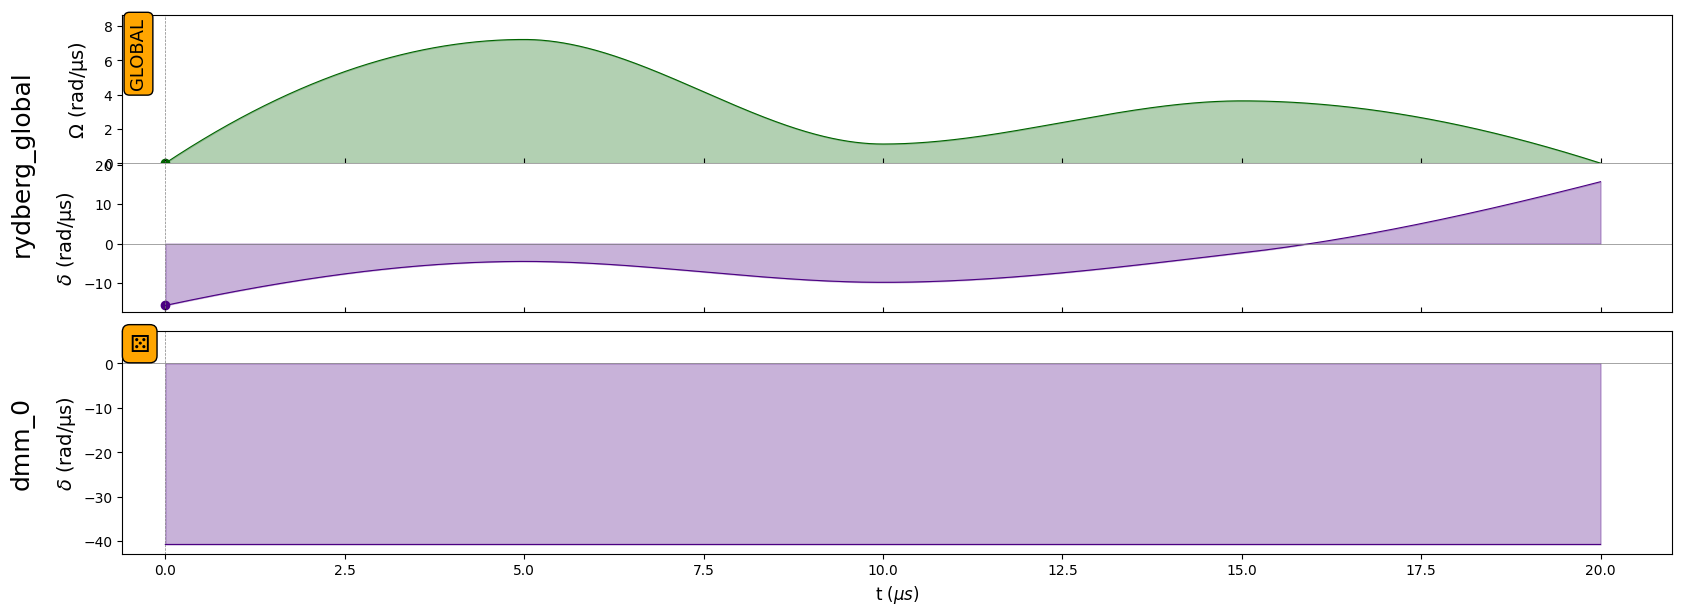

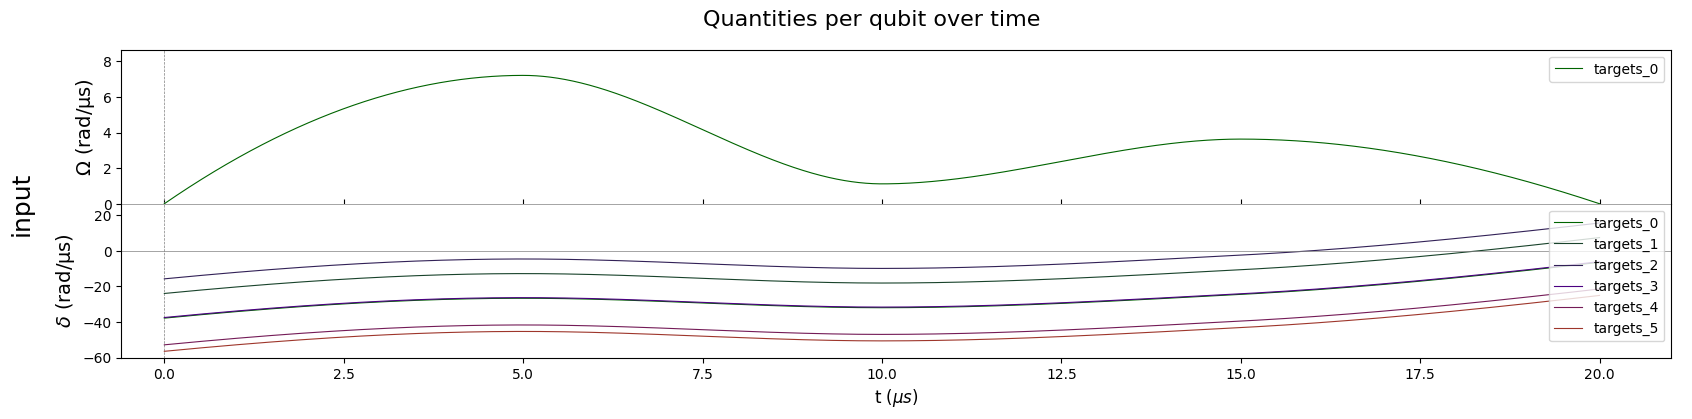

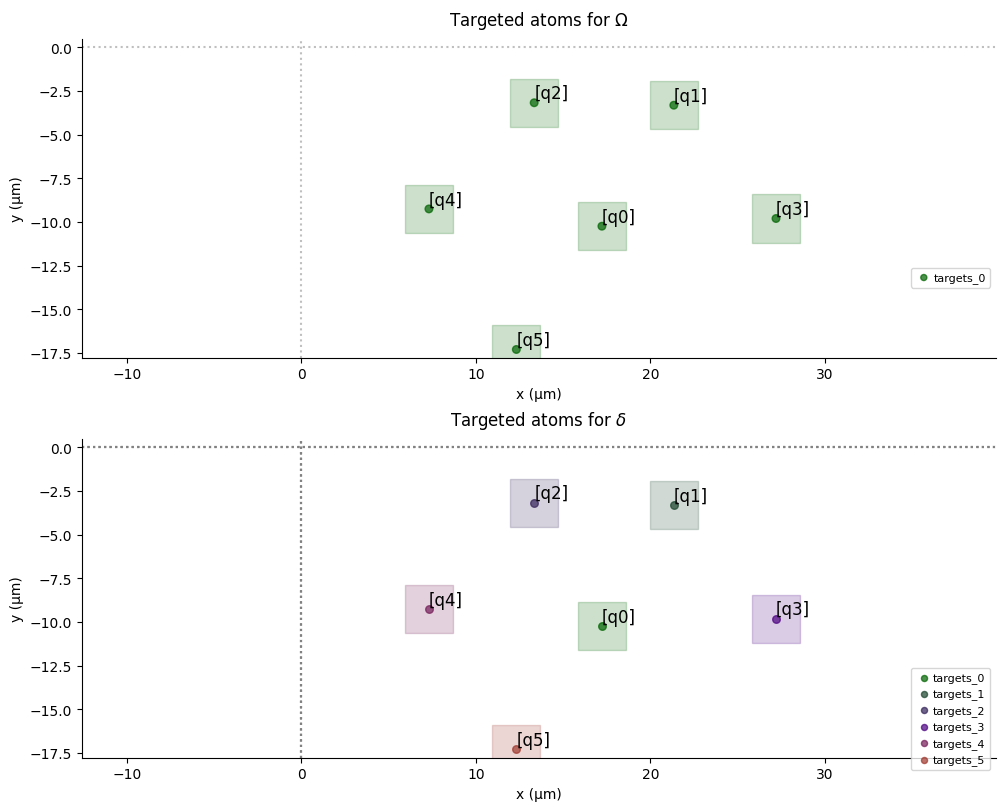

In [9]:
# Random instance of the parameter space
np.random.seed(909)
amp_params = np.random.uniform(0, Omega_max, m)
det_params = np.random.uniform(delta_0, delta_f, m)
dmm_shift = np.random.uniform(-max_det, -delta_f)

sequence.add(optim.create_interp_pulse(amp_params, det_params, delta_bounds, T), "rydberg_global")
sequence.add_dmm_detuning(pulser.ConstantWaveform(T, dmm_shift), "dmm_0")
sequence.draw(
    draw_detuning_maps=True,
    draw_qubit_det=True,
    draw_qubit_amp=True,
)

We can see that our code works and that we have successfuly set up a parametrized interpolated Sequence that works on our device. If we simulate this random Sequence, we will get some random output. Thus, we can continue to obtain the optimized Sequence for the QAA using the Bayesian optimization method.

### 3.2 Optimal control of the Sequence using Bayesian search

In order for the optimization algorithm to choose the best state, we need to define a score function that encodes how 'good' a given set of parameters is for our problem. Here, the score function we are trying to minimize can be defined as the following: $$\min_{z}z^{T}Qz$$ which is just the QUBO cost function, which has been defined in the `score` function in the cell below. Thus, the algorithm tunes the pulse parameters in order to minimize the QUBO cost and thereby obtain the optimal Sequence for the QAA. Next, we define the `score` function:

In [10]:
def score(params):# ,showcase=False, return_b=False):
    """
    Evaluates a pulse configuration by simulating the quantum system and computing its score. The score needs to be minimized in the Bayesian Optimization.        
    scikit-optimize requires this function to have only one argument, so we must define it here and not in optim.py so that the function can have access to the register, device, and Q matrix.

    Parameters:
    params : list  - Contains the 2*m+1 pulse parameters (m for amplitudes, m for detunings, and 1 for the detuning map offset).

    Returns:
    float - Computed score of the sampled bitstring. 
    """
    seq = pulser.Sequence(reg, device)
    seq.declare_channel("rydberg_global", "rydberg_global")
    
    diag_costs = np.diag(Q)
    det_map_weights = optim.normalize_det_map(diag_costs)
    det_map = reg.define_detuning_map({f"q{i}": det_map_weights[i] for i in range(len(det_map_weights))})
    
    seq.config_detuning_map(det_map, "dmm_0")
    
    seq.add(optim.create_interp_pulse(params[:m], params[m:-1], delta_bounds, T), "rydberg_global")
    seq.add_dmm_detuning(pulser.ConstantWaveform(T, params[-1]), "dmm_0")

    simul = pulser_simulation.QutipEmulator.from_sequence(seq, sampling_rate=0.5)
    results = simul.run()
    count_dict = results.sample_final_state(N_samples=1000)
    b = max(count_dict, key=count_dict.get)
    score = optim.get_cost_bitstring(b, Q)
    
    return score

Now we can perform the pulse optimization by using `gp_minimize` from the `scikit-optimize` package, which performs the Bayesian search method on our score function. In the following cell, we define the bounds of our parameter space, the parameters of the optimization, and run the optimization itself.

In [11]:
bounds = [(0.0, Omega_max)] * m + [(-max_det, max_det)] * m + [(-(max_det - delta_f), 0)] # setting up the parameter bounds

n_r = 30 # number of random starts
n_c = 40 # number of iterations for the Bayesian search - these parameters have been sufficient for most of our test cases

RESULT = gp_minimize(score, bounds, n_random_starts=n_r, n_calls=n_c, verbose=True, random_state=909) # set verbose to False to suppress the gp_minimize output

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.0454
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7968
Function value obtained: -26.6332
Current minimum: -26.6332
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7632
Function value obtained: -18.0108
Current minimum: -26.6332
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9271
Function value obtained: -26.4214
Current minimum: -26.6332
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.4870
Function value obtained: -15.0291
Current minimum: -26.6332
Iteration No: 6 sta

The optimization is done, and we can see that **the minimum is the same as the cost of the solution bitstring from the classical solution** of the QUBO above. Thus, the **optimization is successful!** We can now proceed to simulating this optimal sequence and visualizing the results.

In the deployed QuRAWC in realtime, the resultant bitstring would be passed on to the firefighters as the strategy for the next time step.

## 4. Performing the final simulation

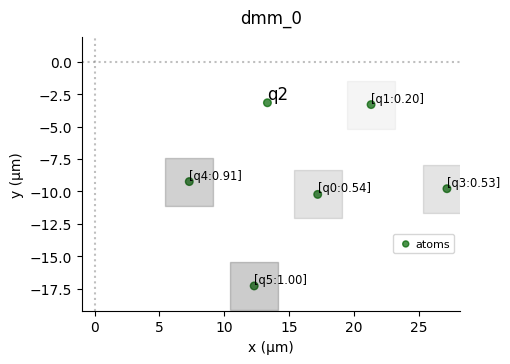

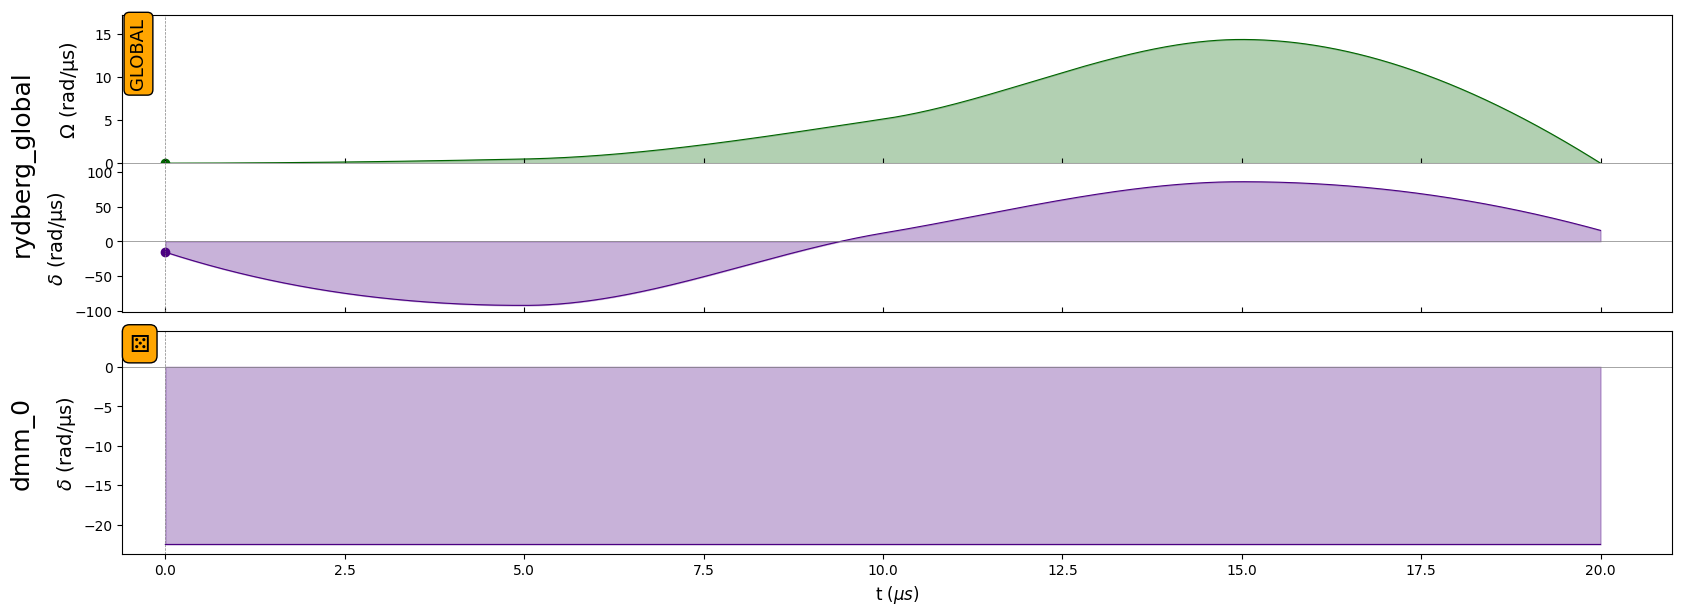

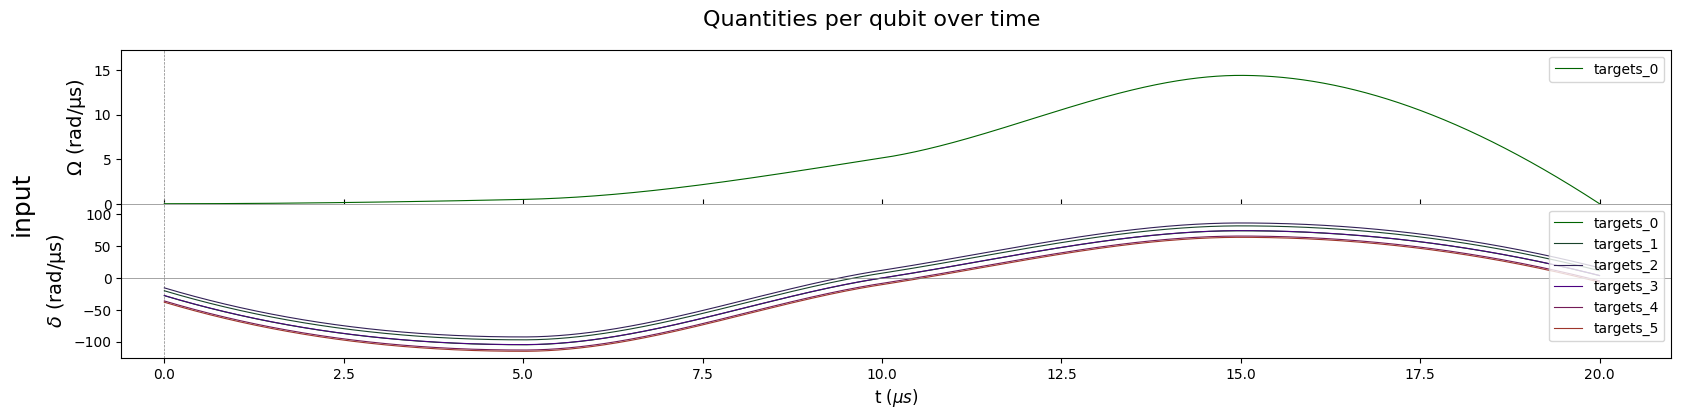

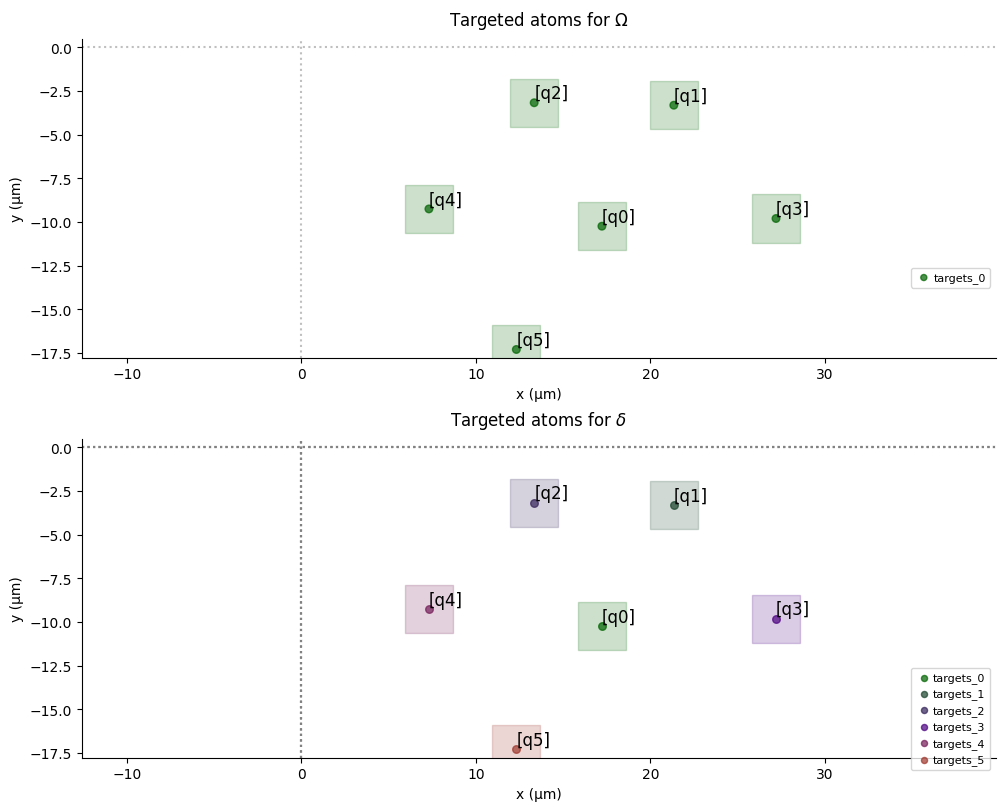

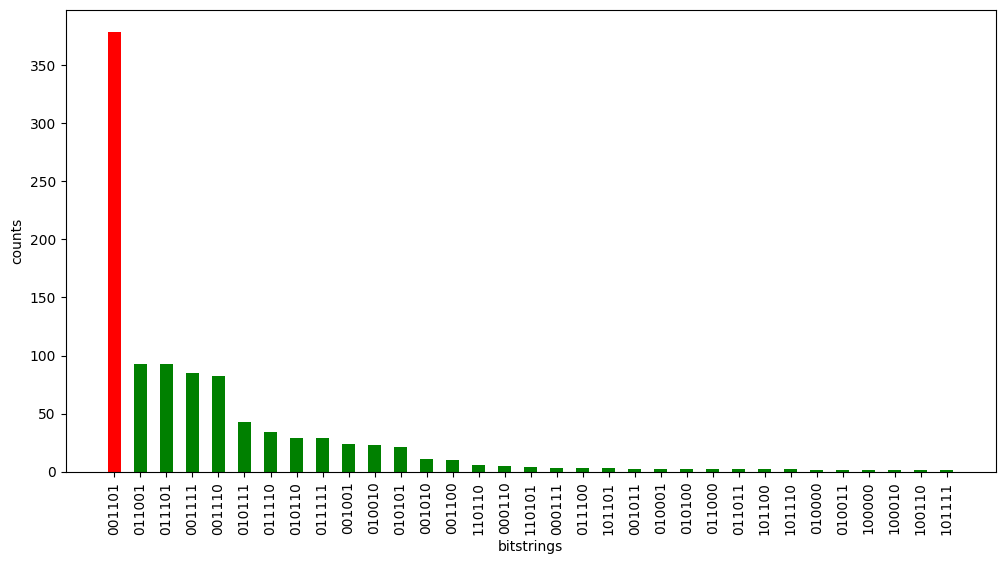

The correct bitstring(s):
001101


In [12]:
seq = pulser.Sequence(reg, device)
seq.declare_channel("rydberg_global", "rydberg_global")

diag_costs = np.diag(Q)
det_map_weights = optim.normalize_det_map(diag_costs)
det_map = reg.define_detuning_map({f"q{i}": det_map_weights[i] for i in range(len(det_map_weights))})

seq.config_detuning_map(det_map, "dmm_0")

seq.add(optim.create_interp_pulse(RESULT.x[:m], RESULT.x[m:-1], delta_bounds, T), "rydberg_global")
seq.add_dmm_detuning(pulser.ConstantWaveform(T, RESULT.x[-1]), "dmm_0")

simul = pulser_simulation.QutipEmulator.from_sequence(seq, sampling_rate=0.5)
results = simul.run()
count_dict = results.sample_final_state(N_samples=1000)

seq.draw(
    draw_detuning_maps=True,
    draw_qubit_det=True,
    draw_qubit_amp=True,
)
optim.plot_distribution(count_dict, sort_zipped[0][0]) # this function plots the counts of the simulation in a histogram, with the correct answer labeled in red

## 5. Conclusion

From the plot above, we can see that the QAA was indeed successful and that the QUBO problem has been solved. It is worth noting that this notebook is merely a showcase of how the quantum optimization is done in QuRAWC, and in the full algorithm all of this is done automatically in real time. For more information on how this procedure is made robust under realtime conditions,i.e. solving bigger $Q$ matrices that might be less ideal, refer to the `QuRAWC_tuto.ipynb` notebook and the Technical Project Report deliverable.